In [1]:
import pprint

import astropy.constants as const
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update({'font.size': 16, 'figure.figsize': (14.0, 8.0)})
import numpy as np
from scipy import optimize, special, stats
import pandas as pd

In [2]:
# Load light curve data

def load_data(lc_file):

    def num_lines(fname):
        with open(fname) as f:
            i = 0
            for i, l in enumerate(f, 1):
                pass
        return i

    num_bins = num_lines(lc_file) - 1  # 1-line header
    print("Light curve has {} bins total".format(num_bins))
    bin_starts = np.zeros(num_bins, dtype='float')  # MJD
    bin_ends = np.zeros(num_bins, dtype='float')  # MJD
    bin_fluxes = np.zeros(num_bins, dtype='float')  # ph/cm^2/s
    bin_flux_errs = np.zeros(num_bins, dtype='float')  # ph/cm^2/s
    bin_ts = np.zeros(num_bins, dtype='float')
    bin_sun_in_roi = np.zeros(num_bins, dtype='bool')

    with open(lc_file) as f:
        for i, line in enumerate(f, -1):
            if i < 0:
                continue
            values = line.strip().split()
            if values[-1] == '*':
                bin_sun_in_roi[i] = True
                del values[-1]
            bin_starts[i], bin_ends[i], bin_fluxes[i], bin_flux_errs[i], bin_ts[i] = values


    # Remove bins with no detection or with possible sun contamination
    good_bins = np.logical_and(bin_ts > 9, ~bin_sun_in_roi)
    bin_starts = bin_starts[good_bins]
    bin_ends = bin_ends[good_bins]
    bin_fluxes = bin_fluxes[good_bins]
    bin_flux_errs = bin_flux_errs[good_bins]
    bin_ts = bin_ts[good_bins]
    bin_sun_in_roi = bin_sun_in_roi[good_bins]

    bin_centers = np.mean(np.array([bin_starts, bin_ends]), axis=0)  # MJD
    bin_spacing = np.mean(bin_ends - bin_starts)
    mean_flux = np.mean(bin_fluxes)
    median_flux = np.median(bin_fluxes)
    print("Light curve has {} bins passing cuts".format(len(bin_fluxes)))
    print("Bin spacing is {} days".format(bin_spacing))
    print("Bin mean flux is {:.04} ph cm^-2 s^-1".format(mean_flux))
    print("Bin median flux is {:.04} ph cm^-2 s^-1".format(median_flux))
    
    return bin_centers, bin_fluxes, bin_flux_errs, bin_ts

In [3]:
# Lightcurve results files from Janeth
sources = [{'prefix': '3C279', 'binsize': 1, 'name': "3C 279"},
           {'prefix': '4C_21p35', 'binsize': 3, 'name': "PKS 1222+216"},
           {'prefix': 'ton599', 'binsize': 7, 'name': "Ton 599"},]

for i, source in enumerate(sources):
    lc_file = "fermi_lc/{prefix}_lc{binsize}_LAT.txt".format(**source)
    bin_centers, bin_fluxes, bin_flux_errs, bin_ts = load_data(lc_file)
    sources[i]['bin_centers'] = bin_centers
    sources[i]['bin_fluxes'] = bin_fluxes
    sources[i]['bin_flux_errs'] = bin_flux_errs
    sources[i]['bin_ts'] = bin_ts

Light curve has 3671 bins total
Light curve has 2289 bins passing cuts
Bin spacing is 1.0 days
Bin mean flux is 9.111e-07 ph cm^-2 s^-1
Bin median flux is 4.924e-07 ph cm^-2 s^-1
Light curve has 1234 bins total
Light curve has 799 bins passing cuts
Bin spacing is 3.0 days
Bin mean flux is 5.065e-07 ph cm^-2 s^-1
Bin median flux is 2.796e-07 ph cm^-2 s^-1
Light curve has 534 bins total
Light curve has 402 bins passing cuts
Bin spacing is 7.0 days
Bin mean flux is 1.953e-07 ph cm^-2 s^-1
Bin median flux is 1.236e-07 ph cm^-2 s^-1


In [4]:
def normal(x, mu, sigma):
    return stats.norm.pdf(x, loc=mu, scale=sigma)

def binormal(x, mu1, sigma1, mu2, sigma2):
    return normal(x, mu1, sigma1) + normal(x, mu2, sigma2)

def lognormal(x, mu, sigma):
    return stats.lognorm.pdf(x, sigma, scale=np.exp(mu))

def bilognormal(x, mu1, sigma1, mu2, sigma2):
    return lognormal(x, mu1, sigma1) + lognormal(x, mu2, sigma2)

# Stochastic model of Tavecchio, Bonnoli, & Galanti (2020)
# as defined in Appendix A
def tbg20(x, mu, lmbda):
    # Perform the computation in log space to avoid overflow errors
    log_numerator = (1 + lmbda)*np.log(lmbda*mu) - special.gammaln(1 + lmbda) - lmbda*mu/x
    denominator = x**(lmbda + 2)
    return np.exp(log_numerator) / denominator

def chisquare(obs, exp, err, num_parameters=None):
    """Compute the reduced chi^2 fit to the model.
    
    See https://www.astroml.org/book_figures/chapter4/fig_chi2_eval.html
    """
    num_counts = len(obs)
    if num_parameters is None:
        num_parameters = 0
    
    z = (obs - exp) / err
    chi2 = np.sum(z**2)
    chi2dof = chi2 / (num_counts - num_parameters)
    sigma = np.sqrt(2. / (num_counts - 1))
    nsig = (chi2dof - 1) / sigma
    return chi2dof, nsig

# Method used by Meyer, Scargle, & Blandford (2019) to calculate the errors on the histogram bins
# See footnote 10 on page 7 of that paper
def bin_errors(flux, flux_err, bin_edges):
    """Calculate bin errors assuming the fluxes are distributed as Gaussians"""
    
    def erf_term(f):
        return special.erf((f - flux[:, None]) / np.sqrt(2 * flux_err[:, None]**2))
    
    F_lo, F_hi = bin_edges[:-1], bin_edges[1:]
    prob = 0.5*(erf_term(F_hi) - erf_term(F_lo))
    return np.sum(prob*(1 - prob), axis=0)


def bootstrap_errors(flux, flux_err, bin_edges):
    """Calculate bin errors using bootstrapping"""
    np.random.seed(0)
    num_samples = len(flux)
    num_bootstraps = 2500
    indices = np.arange(num_samples)
    samples = np.random.choice(indices, (num_samples, num_bootstraps))
    sim_fluxes = np.random.normal(flux[samples], flux_err[samples])
    sim_fluxes = np.clip(sim_fluxes, 1e-10, np.inf)
    sim_hists = np.zeros((len(bin_edges) - 1, num_bootstraps))
    for j in range(num_bootstraps):
        sim_hists[:, j] = np.histogram(sim_fluxes[:, j], bins=bin_edges)[0]
    sim_errs = np.std(sim_hists, axis=1)
    return sim_errs

{'3C 279': {'Log-normal': {'mu': 1.649675516248448,
                           'mu_err': 0.01572907189913974,
                           'sigma': 0.734216253281555,
                           'sigma_err': 0.013198431118305634},
            'SDE': {'lambda': 1.010917983940885,
                    'lambda_err': 0.06123130084661224,
                    'mu': 8.633512761974835,
                    'mu_err': 0.2820814232796638}},
 'PKS 1222+216': {'Log-normal': {'mu': 1.0744205167921534,
                                 'mu_err': 0.03437623055665576,
                                 'sigma': 0.919315168468113,
                                 'sigma_err': 0.029019665822015935},
                  'SDE': {'lambda': 0.5370070359784359,
                          'lambda_err': 0.07799580640660134,
                          'mu': 6.269389264573704,
                          'mu_err': 0.6042287320713303}},
 'Ton 599': {'Log-normal': {'mu': 0.20596106945664155,
                            'mu_err':

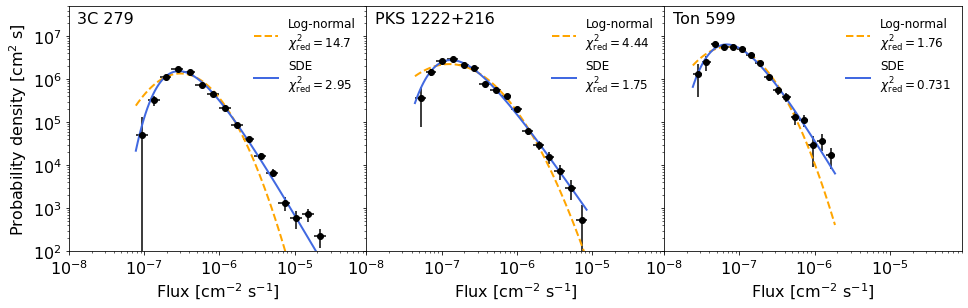

In [5]:
dists = [('Log-normal', lognormal, ('mu', 'sigma'), (1, 0.5)), ('SDE', tbg20, ('mu', 'lambda'), (5, 0.5))]
fit_params = {}

fig, axes = plt.subplots(ncols=3, sharey=True, figsize=(16.0, 4.5))
fig.subplots_adjust(wspace=0)

flux_norm = 1e-7  # ph cm^-2 s^-1

flare_thresholds = [4e-6, 5e-7, 8e-7]

for i, source in enumerate(sources):
    
    flux = source['bin_fluxes'] / flux_norm
    flux_err = source['bin_flux_errs'] / flux_norm
    __, bin_edges = np.histogram(np.log10(flux), bins=16)
    ## Eliminate the lowest-energy bins that may be affected by the TS cutoff
    # bin_edges = bin_edges[4:]
    hist, bin_edges = np.histogram(flux, bins=10**bin_edges, density=True)
    hist_bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    hist_bin_sizes = np.diff(bin_edges) / 2
    hist_errs = bootstrap_errors(flux, flux_err, bin_edges) / np.diff(bin_edges) / len(flux)
    
    axes[i].errorbar(hist_bin_centers*flux_norm, hist/flux_norm,
                 xerr=hist_bin_sizes*flux_norm, yerr=hist_errs/flux_norm,
                 marker='o', linestyle='none', color='k')
    
    fit_params[source['name']] = {}
    styles = [{'linestyle': '--', 'color': 'orange'}, {'linestyle': '-', 'color': 'royalblue'}]
    for (name, pdf, param_names, p0), style in zip(dists, styles):
        params, pcov = optimize.curve_fit(pdf, hist_bin_centers, hist, p0=p0,
                                         bounds=((1e-8, 0), (np.inf, np.inf)),
                                         sigma=hist_errs, absolute_sigma=True,
                                         method='trf')
        for j, (param_name, param) in enumerate(zip(param_names, params)):
            dic = fit_params[source['name']].setdefault(name, {})
            dic[param_name] = param
            dic[param_name + '_err'] = np.sqrt(np.diag(pcov))[j]
        x = np.logspace(np.log10(bin_edges[0]), np.log10(bin_edges[-1]), 100)
        chi2, sigma = chisquare(hist, pdf(hist_bin_centers, *params), hist_errs,
                                num_parameters=len(params))
        label = "{}\n$\chi_{{\mathrm{{red}}}}^2=${:.03}".format(name, chi2)
        axes[i].plot(x*flux_norm, pdf(x, *params)/flux_norm, linewidth=2, label=label, **style)
    
    axes[i].set_xlim([1e-8, 9e-5])
    axes[i].set_ylim([1e2, 5e7])
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')
    axes[i].set_xlabel("Flux [cm$^{-2}$ s$^{-1}$]")
    axes[i].text(1.3e-8, 2e7, source['name'])
    axes[i].legend(fontsize=12, frameon=False)
    
axes[0].set_ylabel("Probability density [cm$^2$ s]")
plt.savefig(fname="flux_distributions.png", bbox_inches='tight', format='png')

pprint.pprint(fit_params)

In [6]:
# Estimate the coefficient of the stochastic term sigma^2
# Use the analytic expression resulting from maximization of the pseudo-likelihood (TBG20 Eq. 7)

# 3C 279: Hayashida et al. (2014)
# PKS 1222+216: Farina et al. (2012)
# Ton 599: Liu, Jiang, & Gu (2006)
bh_masses = np.array([5e8, 6e8, 3.47e8]) * u.M_sun

def estimate_sigma2(t, x):
    numerator = np.diff(x)**2
    denominator = x[:-1]**2 * np.diff(t)
    return np.sum(numerator / denominator) / (len(x) - 1)

thetas = []
for source, bh_mass in zip(sources, bh_masses):
    sigma2 = estimate_sigma2(source['bin_centers'], source['bin_fluxes']) / u.day
    theta = sigma2 * fit_params[source['name']]['SDE']['lambda'] / 2
    r_g = const.G*bh_mass / const.c**2
    theta_timescale = const.c / (theta * r_g)
    sigma_timescale = const.c / (sigma2 * r_g)
    thetas.append(theta.to_value(u.Hz))
    print("Estimated B variability timescale of {}: {:.2f} r_g / c".format(source['name'],
          theta_timescale.to_value(u.dimensionless_unscaled)))
    print("Estimated amplification/dissipation timescale of {}: {:.2f} r_g / c".format(source['name'],
          sigma_timescale.to_value(u.dimensionless_unscaled)))
    print("Estimated sigma^2: {:.3}, theta: {:.3}\n".format(sigma2, theta))

Estimated B variability timescale of 3C 279: 196.34 r_g / c
Estimated amplification/dissipation timescale of 3C 279: 99.24 r_g / c
Estimated sigma^2: 0.354 1 / d, theta: 0.179 1 / d

Estimated B variability timescale of PKS 1222+216: 688.81 r_g / c
Estimated amplification/dissipation timescale of PKS 1222+216: 184.95 r_g / c
Estimated sigma^2: 0.158 1 / d, theta: 0.0424 1 / d

Estimated B variability timescale of Ton 599: 1745.20 r_g / c
Estimated amplification/dissipation timescale of Ton 599: 820.25 r_g / c
Estimated sigma^2: 0.0616 1 / d, theta: 0.029 1 / d



In [7]:
def add_err(val1, val2, err1, err2):
    return np.sqrt(err1**2 + err2**2)

def mul_err(val1, val2, err1, err2):
    return val1*val2*np.sqrt((err1/val1)**2 + (err2/val2)**2)

def div_err(val1, val2, err1, err2):
    return val1/val2*np.sqrt((err1/val1)**2 + (err2/val2)**2)

In [8]:
# Estimate the duty cycle of the three sources

edges = np.logspace(-9, -2, 10000)
x = (edges[:-1] + edges[1:]) / 2
x_width = np.diff(edges)

duty_cycle_factor = 10

for i, source in enumerate(sources):
    params = fit_params[source['name']]['SDE']
    mu, mu_err, lmbda, lmbda_err = params['mu'], params['mu_err'], params['lambda'], params['lambda_err']
    pdf = tbg20(x/flux_norm, mu, lmbda) / flux_norm
    peak = mu*flux_norm * lmbda / (lmbda + 2)
    peak_err = flux_norm*div_err(mu*lmbda, lmbda + 2, mul_err(mu, lmbda, mu_err, lmbda_err), lmbda_err)
    mass = pdf * x_width
    cummass = np.cumsum(mass)
    time_frac = 1 - cummass[x > duty_cycle_factor*peak][0]
    print(">{}x peak: {:.0f}%".format(duty_cycle_factor, 100*time_frac))

>10x peak: 4%
>10x peak: 8%
>10x peak: 4%


In [9]:
# Estimate the effect of measurement uncertainty on the calculated sigma^2 using bootstrapping
    
for source, bh_mass in zip(sources, bh_masses):
    np.random.seed(0)
    num_bootstraps = 10000
    size = (num_bootstraps,) + source['bin_fluxes'].shape
    sim_flux = np.random.normal(source['bin_fluxes'], source['bin_flux_errs'], size=size)
    sigma2s = np.zeros(num_bootstraps)
    for i in range(num_bootstraps):
        mask = sim_flux[i] >= 1*np.min(source['bin_fluxes'])
        sigma2s[i] = estimate_sigma2(source['bin_centers'][mask], sim_flux[i][mask])
    print("{:.03} +- {:.03}".format(np.mean(sigma2s), np.std(sigma2s)))

0.87 +- 0.136
0.266 +- 0.0496
0.105 +- 0.02
